In [2]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support.select import Select
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import jieba
from IPython.core.display import display, HTML
from datetime import datetime
import time
from datetime import date, timedelta
from datetime import datetime
import re


class Ptt(object):
    fp = "/Users/cindy/Desktop/pg/mit/fun"
    dp = "/Users/cindy/Desktop/pg/driver/chromedriver"
    dm = "https://www.ptt.cc"
    
    def __init__(self, board, updatedate, pages): 
        self.lastdt = ( date.today() - timedelta(updatedate))#.strftime("%m/%d").lstrip("0")
        self.brd = board
        self.lastidx = 0
        self.data = []
        self.page_num = pages
        self.webres = None

        
    def start(self):    
        self.driver = webdriver.Chrome(self.dp)
        self.url = "{}/bbs/{}/index{}.html".format(self.dm, self.brd, self.lastidx)
       
    def end(self):
        self.driver.close()
        self.driver.quit()
    
    def getIndex(self):
        self.driver.get(self.url)
        self.webres = BeautifulSoup(self.driver.page_source, "lxml")
        # over 18 check
        btns18 = self.webres.find_all("div", class_ = "over18-button-container")
        if len(btns18) != 0:
            self.driver.find_element_by_name("yes").click()
            self.webres = BeautifulSoup(self.driver.page_source, "lxml")
        self.lastidx =  1 + int(self.webres.find_all("a", class_ = "btn wide")[1]["href"].replace("index","").replace(".html","").split("/")[3])   
 
    def getposts(self):
        self.start()
        self.getIndex() 
        
        for i in range(self.lastidx-self.page_num+1, self.lastidx+1): 
            self.url = "{}/bbs/{}/index{}.html".format(self.dm, self.brd, i)  
            self.driver.get(self.url)
            self.webres = BeautifulSoup(self.driver.page_source, "lxml")
            
            # over 18 check
            btns18 = self.webres.find_all("div", class_ = "over18-button-container")
            if len(btns18) != 0:
                self.driver.find_element_by_name("yes").click()
                self.webres = BeautifulSoup(self.driver.page_source, "lxml")
            
            posts = self.webres.find_all("div", class_ = "r-ent")
            for p in posts:
                title = p.find("div", class_="title").getText().strip() 
                if title is not None:
                    dt = p.find("div", class_ = "date").text.strip() 
                    ardt = datetime.strptime("2018/{}".format(dt), "%Y/%m/%d").date()

                    if self.lastdt <= ardt:
                        keywords = ["徵才","徵","找人","求才","找","求"]
                        words = [j for j in jieba.cut_for_search(re.sub('[\W\d_]+', ' ', title)) if j in keywords]
                        if len(words) > 0 :          
                            url = p.find("a")["href"]
                            athr = p.find("div", class_ = "author").getText()
                            tmpcmt = p.find("div", class_ = "nrec").text
                            cmt = int(tmpcmt) if tmpcmt.isdigit() else np.nan
                            self.data.append([self.brd, dt, cmt, title, url])
                            display(HTML("<a href='{}{}' target='_blank' >{} {} {}</a>".format(self.dm, url, self.brd, dt, title))) 
        self.end()

jobs = ["Soft_Job", "Tech_Job","WorkinChina","Oversea_Job","Job","TaiwanJobs"]
alljob = []
for i in jobs:
    p = Ptt(i, 1, 5)
    p.getposts()
    alljob.append(p.data)
from functools import reduce
alljob = reduce(lambda x,y: x+y, alljob)

col = ['brd','date','cmt','title','url']
result = pd.DataFrame(alljob, columns=col)


In [3]:
import re
stopwords = ['Re','DELETE',' ', '沒', '才', '第', '的', '次', '了', '和', '是', '就', '都', '而', '及', '與', '一個', '沒有', '我們', '你們', '妳們', '他們', '她們', '是否', '一', '不', '在', '人', '有', '為', '以', '於', '上', '他', '後', '之', '來', '因', '下', '可', '到', '由', '這', '也', '此', '但', '並', '個', '其', '已', '無', '小', '我', '們', '起', '最', '再', '今', '去', '好', '只', '又', '或', '很', '亦', '某', '把', '那', '你', '乃', '它', '吧', '被', '比', '別', '趁', '當', '從', '到', '得', '打', '凡', '兒', '爾', '該', '各', '給', '跟', '何', '還', '即', '幾', '既', '看', '據', '距', '靠', '啦', '了', '另', '麼', '每', '們', '嘛', '拿', '哪', '那', '您', '憑', '且', '卻', '讓', '仍', '啥', '如', '若', '使', '誰', '雖', '隨', '同', '所', '她', '哇', '嗡', '往', '哪', '些', '向', '沿', '喲', '用', '於', '咱', '則', '怎', '曾', '至', '致', '著', '諸', '自']
words = [j for i in result['title'] for j in jieba.cut_for_search(re.sub('[\W\d_]+', ' ', i)) if j not in stopwords]
wdf = pd.DataFrame(words, columns=['word'])
r = wdf['word'].value_counts().to_frame(name='cnt')
print(r[1:10])
from PIL import Image
word_space = ' '.join(words) 
img = np.array(Image.open('/Users/cindy/Downloads/heart.png'))

     cnt
徵才    17
師     12
工程    12
等      8
職位     8
台北     8
Fw     6
iOS    4
軟體     4


(-0.5, 899.5, 899.5, -0.5)

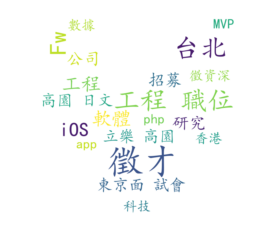

In [47]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create and generate a word cloud image:

# wordcloud = WordCloud().generate(word_space)
my_wordcloud = WordCloud(
    background_color='white', #设置背景颜色
    scale=1.5,
    mask=img,  #背景图片
    max_words = 20, #设置最大显示的词数
#     stopwords = STOPWORDS, #设置停用词
    #设置字体格式，字体格式 .ttf文件需自己网上下载，最好将名字改为英文，中文名路径加载会出现问题。
    font_path = '/Users/cindy/Downloads/simkai.ttf', 
    max_font_size = 100, #设置字体最大值
    random_state=45, #设置随机生成状态，即多少种配色方案
    ).generate(word_space)

# import matplotlib.pyplot as plt
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis("off")
my_wordcloud.to_file('/Users/cindy/Downloads/res.jpg')


In [222]:
import requests
import pandas as pd 
from dateutil.parser import parse


# 在Facebook Graph API Exploer取得token

token = 'EAACEdEose0cBAFuvuZAX3ZBP2KyZBHxXpU3athgfffKLkbebFJDXciLlSHNXhbwbCZBFwBITpE6iFw5MEhzRMpOZAb1HUfOTByZB6l0s7ELTZCB5RlwiloPWaA6WzhRBVYFXyZC3osB1fu5XqyLo3tUy1rnuIZC3f4wUGoZAh1oYMDS6N0HIWne75NAZBDJaZCVLIgySKHA5WMlgPdVuzGeozuF2hGZBIVL2qYx4lrUDqx0tSawZDZD'
# 在Facebook Graph API Exploer取得粉絲專頁的id與名稱，並將其包成字典dic

fanpages = {'137698833067234':'資料視覺化 / Data Visualization',
           '1703467299932229':'Data Man 的資料視覺化筆記'} 
limit = 1
# 建立一個空的list        

information_list = []

# 使用for迴圈依序讀取粉絲頁的資訊，並使用format將id與token傳入{}裡

for fanpage_id in fanpages:
    res = requests.get('https://graph.facebook.com/v2.12/{}/posts?limit=100&access_token={}'.format(fanpage_id, token))

    # API最多一次呼叫100筆資料，因此使用while迴圈去翻頁取得所有的資料

    pages = 1  # 初始化爬取頁數 
    while True: 
        if pages <= limit :
            print('目前正在爬取 {} {} 第{}頁'.format(fanpage_id, fanpages[fanpage_id], pages))
            for information in res.json()['data']:
                if 'message' in information:
                    information_list.append([fanpages[fanpage_id], information['message'], parse(information['created_time']).date()])

            # 若有下一頁，則繼續爬取，否則跳出While迴圈

            if 'next' in res.json()['paging']:
                res = requests.get(res.json()['paging']['next'])
                pages += 1
            else:
                print('{} {} 已爬取完成! \n'.format(fanpage_id, fanpages[fanpage_id]))
                break
        else :
            break

# 最後將list轉換成dataframe，並輸出成Excel檔
# information_df = pd.DataFrame(information_list, columns=['粉絲專頁', '發文內容', '發文時間']) 
# print(information_df[0:3])
# information_df.to_excel('Data Visualization Information.xlsx', index=False) 

目前正在爬取 137698833067234 資料視覺化 / Data Visualization 第1頁
目前正在爬取 1703467299932229 Data Man 的資料視覺化筆記 第1頁
